In [138]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [139]:
import mne
import pandas as pd
import numpy as np

def read_csv(eeg_csv, channels, sfreq = 256, montage = 'standard_1020', useless_cols = ['timestamp', 'sequence', 'battery', 'flags']):
  df = pd.read_csv(eeg_csv)
  df_mne = df.drop(useless_cols, axis=1)

  # Transpose the matrix because MNE expects it like that
  data_mne = df_mne.to_numpy().transpose()

  # Scale the data
  # data_mne = data_mne / 1000000

  # Create MNE Raw's Info object
  info_mne = mne.create_info(
      #ch_names=list(df_mne.columns),
      ch_names=channels,
      ch_types='eeg',
      sfreq=sfreq)

  bbt_raw = mne.io.RawArray(data_mne, info_mne)
  ten_twenty_montage = mne.channels.make_standard_montage(montage)

  raw = bbt_raw.copy().set_montage(ten_twenty_montage)
  return raw

In [140]:
import numpy as np

def filters(raw, fmin = 0.5, fmax = 100., notch = 50., sampling_rate = 250, fir_design = 'firwin'):

    '''Apply high/low-pass and notch filters:

        === Args ===
        * raw - mne Raw object: object to apply filters on
        * fmin, fmax - float: bandpass frequencies
        * notch - float: powerline (AC current) frequecy
        * ny_freq - float: Nyquist frequency. Half of the sampling rate
        * fir_design: str: Notch filter type. See mne doc for more details
        * sampling_rate - int, float: sampling rate of the measured data

        === Returns ===
        * raw_c - mne Raw object: Processed Raw copy
        '''
    raw_c = raw.copy()
    raw_c.filter(l_freq = fmin, h_freq = fmax)
    raw_c.notch_filter(np.arange(notch, sampling_rate/2, notch), fir_design=fir_design)
    return raw_c

from math import floor

def windowfy_dataset(dataframe, chunk_size=100, n_channels=16):
    n_chunks = floor(dataframe.shape[0] / chunk_size)

    windows = np.ndarray(shape=(n_chunks, chunk_size, n_channels), dtype=float)

    channels_array = []
    for i in range(1, n_channels + 1):
        channels_array.append("EEG-ch" + str(i))

    dataframe_as_pd = dataframe[channels_array].to_numpy()
    # shape --> (samplesChannel, nChannels)

    for iChunk in range(n_chunks):
        for iSample in range(chunk_size):
            idf = (iChunk * chunk_size) + iSample
            windows[iChunk][iSample] = dataframe_as_pd[idf]

    return windows

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data

In [142]:
import pandas as pd

eeg_file = "EEG.txt"

df = pd.read_csv(eeg_file)
df.head()

,timestamp,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,EEG-ch7,EEG-ch8,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16
0,153804687683,16336,-2,0,-2553.890054,-6876.865884,31106.838605,214.528663,22527.894451,8132.718209,21134.279463,30553.415250,-10230.794172,-5388.805234,17134.538498,10109.798595,-17322.626756,17221.805220,-10619.150551,9531.200275
1,153804687683,16336,-2,0,-2557.710711,-6880.297175,31105.195966,214.772017,22528.880034,8132.827718,21137.443064,30554.473840,-10229.407054,-5388.087339,17137.081547,10109.774259,-17321.945365,17222.158083,-10620.878364,9531.504468
2,153804687683,16336,-2,0,-2570.961333,-6885.176421,31096.520398,210.002279,22524.438825,8130.528023,21134.948686,30551.626599,-10230.392638,-5389.218935,17135.268560,10101.329878,-17325.364488,17223.642542,-10621.778774,9531.832996
3,153804687683,16336,-2,0,-2585.039358,-6887.330103,31091.774996,201.935096,22518.805181,8127.899801,21129.205533,30548.767190,-10233.677916,-5390.934580,17132.956698,10096.827830,-17330.377579,17223.715548,-10622.642680,9530.056512
4,153804687683,16336,-2,0,-2573.200189,-6886.064663,31095.473976,200.523644,22517.126039,8126.330168,21127.404714,30550.957375,-10236.634666,-5391.761984,17130.401481,10101.926095,-17333.188317,17223.350517,-10622.022128,9527.744649


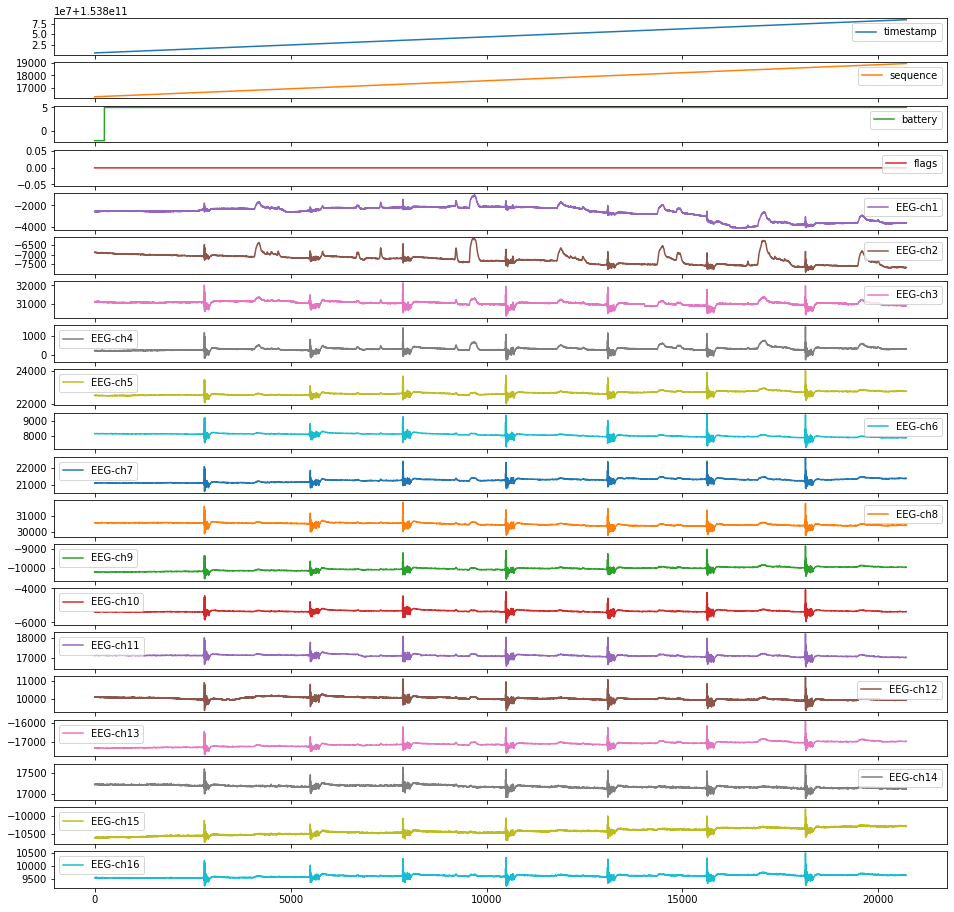

In [143]:
df.plot(subplots=True, figsize=(16, 16));

### Loading Data with BBT to operate on Frequency

In [144]:


raw_rubert = read_csv(eeg_file,
                        ['Fp1', 'Fp2', 'F3', 'F4', 'C1', 'C3', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'CP4', 'Cz', 'O1', 'O2', 'Pz'])

Creating RawArray with float64 data, n_channels=16, n_times=20712
    Range : 0 ... 20711 =      0.000 ...    80.902 secs
Ready.


Effective window size : 8.000 (s)


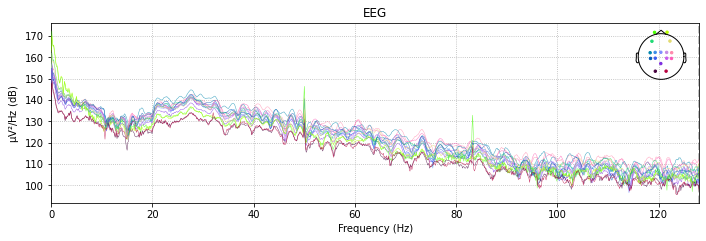

In [145]:
plot_raw = raw_rubert.plot_psd(fmin = 0, fmax = 128, average=False, tmin = 0, tmax = 120)
#plot_raw = raw_rubert.plot_psd(fmin = 0, fmax = 128, average=True, tmin = 0, tmax = 120)
#plot_raw = raw_rubert.plot_psd()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 sec)

Effective window size : 8.000 (s)


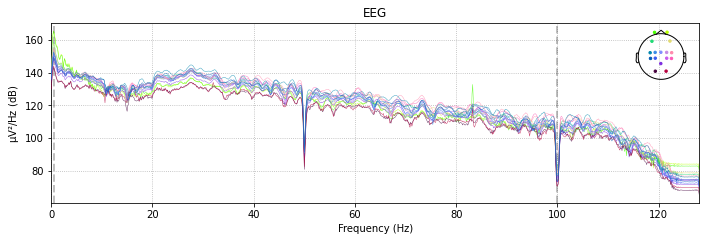

In [146]:
filtered_rubert = filters(raw_rubert)
plot_filtered = filtered_rubert.plot_psd(fmin = 0, fmax = 128, average=False, tmin = 0, tmax = 120)

In [147]:
save_path = '/content/pickle'

df.to_pickle(save_path + 'rubert_jaw_1.pkl')

### Slicing into smaller temporal windows

In [148]:
sampling_rate = 256
window_time = 5 # segs
window_size = window_time * sampling_rate
n_channels = 16

windows = windowfy_dataset(df, window_size, n_channels)

print("---SHAPE---")
print(windows.shape)
print("---DATA---")
print(windows[0])

---SHAPE---
(16, 1280, 16)
---DATA---
[[ -2553.89005386  -6876.86588421  31106.83860482 ...  17221.80521998
  -10619.15055138   9531.20027535]
 [ -2557.71071067  -6880.29717471  31105.19596575 ...  17222.15808319
  -10620.87836433   9531.50446777]
 [ -2570.96133251  -6885.17642114  31096.52039791 ...  17223.6425422
  -10621.77877389   9531.83299558]
 ...
 [ -2558.12441236  -7008.84889165  31051.7554413  ...  17219.40818371
  -10593.74440041   9518.61887683]
 [ -2568.63730241  -7008.82455625  31044.97803417 ...  17213.51901845
  -10596.71331844   9513.97081665]
 [ -2559.62103907  -6998.03180917  31046.51116397 ...  17210.16073412
  -10595.27753021   9512.91222702]]


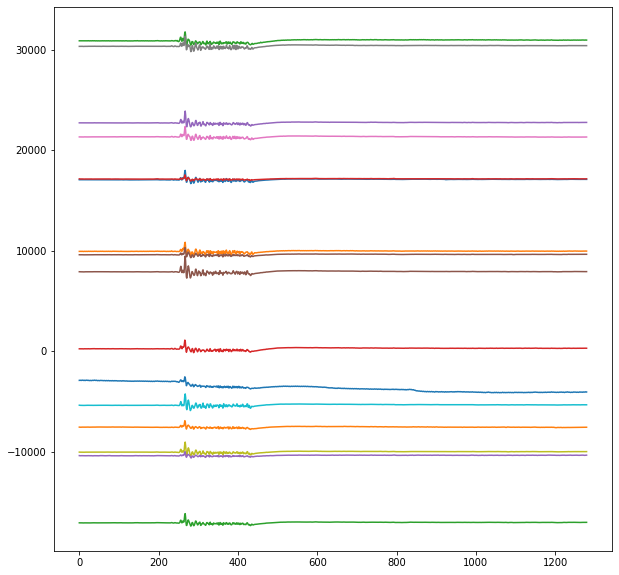

[[ -2892.80908117  -7544.00853331  30891.59204802 ...  17154.98022903
  -10378.24232198   9606.01944311]
 [ -2884.46204115  -7547.8778609   30891.15401094 ...  17148.83554214
  -10387.01523139   9603.02618969]
 [ -2879.47328545  -7549.59350616  30893.72139497 ...  17143.08022154
  -10391.72413006   9602.02843855]
 ...
 [ -4030.51306951  -7554.3997464   30972.45856111 ...  17153.79996244
  -10348.46796785   9643.71496787]
 [ -4043.05796493  -7556.52909335  30966.69107281 ...  17157.13391137
  -10341.72706381   9647.26793534]
 [ -4051.77003586  -7555.50700681  30961.44679548 ...  17160.96673587
  -10332.66212968   9651.35628147]]


In [149]:
import matplotlib.pyplot as plt

# Data sequence
# pause pause signal pause ...

first_window = windows[12]

plt.figure(figsize=(10,10))
plt.plot(first_window)
plt.show()

print(first_window)

### Labeling data

New 


In [162]:
def labelingWindows(windows, artifactLabel):
    windowsMap = {'window': [], 'label': []}
    for i, window in enumerate(windows):
        even = (i % 2) == 0
        label = artifactLabel if (even and i!=0) else "pause"
        windowsMap['window'].append(window)
        windowsMap['label'].append(label)
    df = pd.DataFrame(windowsMap)
    df.columns = ['window', 'label']
    return df

In [163]:
labeledWindows = labelingWindows(windows, 'jaw')

print('---labeled data----')
labeledWindows.head()

---labeled data----


,window,label
0,"[[-2553.8900538641, -6876.8658842094, 31106.83...",pause
1,"[[-2535.5776701456, -6991.3030728292, 31057.07...",pause
2,"[[-2511.4004565584, -7073.5323679586, 31067.73...",jaw
3,"[[-2290.0943867427, -7086.223275745, 31128.290...",pause
4,"[[-2594.2138011353, -7173.3926557845, 31059.74...",jaw


In [164]:
data_windows=pd.DataFrame({'State':labeledWindows['label'],'RawData':labeledWindows['window']})

In [165]:
data_windows['State']=data_windows['State'].replace({'pause': 0, 'jaw': 1})

In [167]:
import warnings
warnings.filterwarnings("ignore")

In [180]:
column_names=[]
for i in range(0,len(data_windows['RawData'][0])+1):
  column_names.append(f'RawData{i}')


In [194]:
df = pd.DataFrame()

for i in range(0,len(data_windows['RawData'][0])):
  for j in range(0,len(data_windows)):
      arr = data_windows['RawData'][j][i]
      df[column_names[i]]=arr
     

In [196]:
df['State']=data_windows['State']

In [200]:
df

,RawData0,RawData1,RawData2,RawData3,RawData4,RawData5,RawData6,RawData7,RawData8,RawData9,...,RawData1271,RawData1272,RawData1273,RawData1274,RawData1275,RawData1276,RawData1277,RawData1278,RawData1279,State
0,-3641.256280,-3631.436949,-3628.614043,-3642.473050,-3652.292381,-3644.809248,-3635.330612,-3623.552282,-3625.012405,-3641.949839,...,-3648.848923,-3651.404140,-3668.536257,-3671.140144,-3653.922853,-3641.450964,-3642.497386,-3651.842177,-3661.904862,0
1,-7589.454881,-7592.411631,-7595.745580,-7597.960101,-7599.700082,-7594.881674,-7591.365209,-7589.832080,-7589.795576,-7591.851917,...,-7659.309628,-7661.219957,-7663.239794,-7661.134783,-7658.579567,-7659.978852,-7659.127113,-7662.850428,-7661.244292,0
2,30959.877163,30959.609473,30956.823071,30947.283596,30940.141158,30946.310181,30955.180432,30964.719906,30965.693322,30958.757734,...,30899.939088,30897.456878,30888.087751,30888.185093,30890.947160,30897.128350,30899.184691,30891.275688,30890.107589,1
3,320.801327,316.433124,315.265025,310.872486,306.297432,310.629132,316.177602,322.456134,321.823413,315.362366,...,287.741694,289.189650,284.943124,282.120219,283.957541,285.977378,287.340160,283.373491,279.528499,0
4,22764.203291,22756.221281,22747.703894,22742.423113,22736.047240,22747.691726,22755.223530,22764.507483,22767.537239,22767.573743,...,22770.287139,22769.459736,22766.332637,22765.055029,22766.332637,22768.109121,22768.413314,22764.994191,22763.716583,1
5,7879.070401,7870.382665,7861.743600,7857.119876,7854.698504,7858.275807,7863.739103,7870.772031,7875.225409,7875.663446,...,7837.420375,7836.592971,7836.288779,7837.043176,7838.478964,7838.880498,7839.586225,7838.284281,7836.033257,0
6,21354.368763,21347.177654,21339.268651,21335.228976,21332.819772,21335.216808,21339.925707,21346.569269,21347.810374,21343.661190,...,21386.162955,21386.150787,21382.390969,21380.285957,21380.821336,21383.035856,21382.865509,21379.628901,21376.830331,1
7,30383.335184,30377.774547,30371.715034,30366.300408,30363.599180,30364.755111,30370.717282,30373.187325,30369.342333,30363.246317,...,30400.734990,30398.155439,30393.641223,30392.095926,30394.529465,30397.376706,30395.904415,30389.370362,30385.926903,0
8,-9968.495131,-9978.837674,-9986.819683,-9990.482160,-9988.547496,-9984.994528,-9979.957102,-9972.096770,-9968.288281,-9967.558219,...,-9981.551070,-9982.159455,-9983.935939,-9983.278883,-9983.072032,-9984.617330,-9984.288802,-9984.775510,-9984.933690,1
9,-5332.249779,-5341.460725,-5349.795598,-5353.604087,-5351.705926,-5349.138542,-5345.938438,-5341.387719,-5337.554895,-5335.583728,...,-5376.686208,-5375.810133,-5376.089990,-5375.359929,-5373.936308,-5373.169743,-5373.291420,-5373.437432,-5372.792545,0


In [209]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

X = df.drop(['State'], axis=1)
y = df['State']
seed = 1234

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, shuffle=True,random_state=seed)


In [205]:
from sklearn.model_selection import train_test_split, GridSearchCV

lr_params = {'C': [9.08, 10.08, 100.08,200.08],
             'max_iter': [100,200, 500, 1000,50000,100000]}
lr_grid = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                       param_grid=lr_params,
                       cv=3).fit(X_train, y_train)


lr_grid.best_estimator_.get_params()

{'C': 9.08,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1234,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [206]:
lr_opt=LogisticRegression(C=9.08, max_iter=100, penalty='l2', random_state=seed)

In [207]:
lr_opt.fit(X_train, y_train)

LogisticRegression(C=9.08, random_state=1234)

In [210]:
lr_opt.score(X_test, y_test)

0.5

In [211]:
y_pred_lr = lr_opt.predict(X_test)

In [215]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
import seaborn as sns

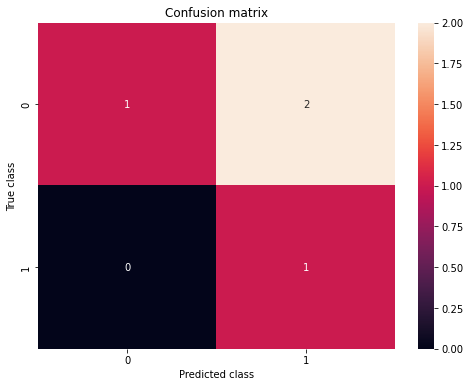

In [216]:
conf_matrix = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])
plt.figure(figsize=[8, 6])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class');